In [18]:
import networkx as nx
from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
import pickle
%matplotlib inline

In [19]:
# # Load graph
# with open("Results/notebook/StellarGraph.p", 'rb') as f:
#     G = pickle.load(f) 

In [32]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

# g = nx.karate_club_graph()
# G = StellarGraph.from_networkx(g)
# nx.draw(g, with_labels=True)
# plt.show()

In [33]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [34]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [35]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


In [36]:
epochs = 50

train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [37]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [38]:
x_inp, x_out = gcn.in_out_tensors()

In [39]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [40]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [41]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/Users/mmarzi/.pyenv/versions/3.8.0/envs/graphs/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [42]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2022-05-04 18:24:46.534675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 0s 49ms/step - loss: 2.4122 - acc: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 2.4239
	acc: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 2.4122
	acc: 0.0000


In [43]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 2.2640 - acc: 0.0000e+00 - val_loss: 0.7161 - val_acc: 0.0000e+00
Epoch 2/50
1/1 - 0s - loss: 0.7358 - acc: 0.0000e+00 - val_loss: 5.5140 - val_acc: 0.0000e+00
Epoch 3/50
1/1 - 0s - loss: 5.1838 - acc: 0.0000e+00 - val_loss: 5.5521 - val_acc: 0.0000e+00
Epoch 4/50
1/1 - 0s - loss: 5.2288 - acc: 0.0000e+00 - val_loss: 1.6510 - val_acc: 0.0000e+00
Epoch 5/50
1/1 - 0s - loss: 1.6375 - acc: 0.0000e+00 - val_loss: 0.6661 - val_acc: 0.0000e+00
Epoch 6/50
1/1 - 0s - loss: 0.6779 - acc: 0.0000e+00 - val_loss: 0.7667 - val_acc: 0.0000e+00
Epoch 7/50
1/1 - 0s - loss: 0.7419 - acc: 0.0000e+00 - val_loss: 0.7861 - val_acc: 0.0000e+00
Epoch 8/50
1/1 - 0s - loss: 0.7637 - acc: 0.0000e+00 - val_loss: 0.7152 - val_acc: 0.0000e+00
Epoch 9/50
1/1 - 0s - loss: 0.7400 - acc: 0.0000e+00 - val_loss: 0.6807 - val_acc: 0.0000e+00
Epoch 10/50
1/1 - 0s - loss: 0.8246 - acc: 0.0000e+00 - val_loss: 0.7108 - val_acc: 0.0000e+00
Epoch 11/50
1/1 - 0s - loss: 0.9939 - acc: 0.0000e+00 - val

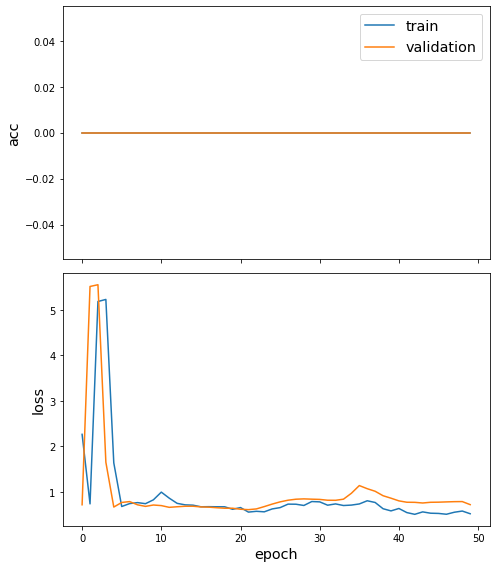

In [44]:
sg.utils.plot_history(history)

In [45]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 50ms/step - loss: 0.7189 - acc: 0.0000e+00

Train Set Metrics of the trained model:
	loss: 0.3856
	acc: 0.0000

Test Set Metrics of the trained model:
	loss: 0.7189
	acc: 0.0000
